# Fine-Tuning the Architecture of LSTM Model

In [ ]:
#!pip install pyswarms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyswarms.single.global_best import GlobalBestPSO
tf.random.set_seed(33)

In [2]:
# Importing data
data = pd.read_csv('Data/Electric_Production.csv')

# Preprocessing
def preprocess_data(data):
    df = pd.DataFrame(data['IPG2211A2N'])
    df['IPG2211A2N'] = df['IPG2211A2N'].apply(lambda x: float(str(x).replace('?', '')))
    return df.astype('float32')
dataset = preprocess_data(data)

In [3]:
# Preparing data for model
dataset = pd.DataFrame(dataset)
dataset = dataset.values
dataset = dataset.astype('float32')

# normalize the dataset with MinMax normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    dataX.append(dataset[i:(i+look_back), 0])
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [4]:
# Define the objective function
def objective_function(params):
    
    Costs = np.zeros(params.shape[0])  
    for i in range(params.shape[0]):
        look_back= int(params[i, 0])
        Nunits= int(params[i, 1])
        activation= int(params[i, 2])
        NLayer= int(params[i, 2])
        
        if activation < 2:
            activation = 'tanh'
        else: 
            activation = 'relu'
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    
    for t in range(1,NLayer+1):
        if t == 1 and NLayer == 1:
            model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back)))
        elif t == 1 and NLayer > 1:
            model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back), return_sequences=True))
        elif t == NLayer:
            model.add(LSTM(units=Nunits, activation=activation))
        else:
            model.add(LSTM(units=Nunits, activation=activation, return_sequences=True)) 

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    
    
    # make predictions
    trainPredict = model.predict(trainX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    
    
    # make predictions
    testPredict = model.predict(testX)
    # invert predictions
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    Cost= (0.1*trainScore + 0.9*testScore)**2
    
    # Return the validation loss as the objective value
    return Cost

In [5]:
# Define hyperparameters 
#look_back, #Nunits, #activation, #NLayer
lower_bound = np.array([4, 4, 1, 1])
upper_bound = np.array([10, 10, 3, 5])
bounds = (lower_bound, upper_bound)

In [6]:
# Initialize the optimizer
options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles= 6, dimensions= 4, options=options, bounds=bounds)

# Run the optimization
best_costs, best_hyperparams = optimizer.optimize(objective_function, iters= 20)

# Print the best hyperparameters found
print("Best position:", best_hyperparams)
print("Best cost:", best_costs)

2024-02-08 19:54:31,384 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/20

Epoch 1/10
308/308 - 4s - loss: 0.0741 - 4s/epoch - 12ms/step
Epoch 2/10
308/308 - 0s - loss: 0.0118 - 478ms/epoch - 2ms/step
Epoch 3/10
308/308 - 1s - loss: 0.0095 - 500ms/epoch - 2ms/step
Epoch 4/10
308/308 - 0s - loss: 0.0079 - 439ms/epoch - 1ms/step
Epoch 5/10
308/308 - 0s - loss: 0.0066 - 484ms/epoch - 2ms/step
Epoch 6/10
308/308 - 0s - loss: 0.0058 - 391ms/epoch - 1ms/step
Epoch 7/10
308/308 - 0s - loss: 0.0053 - 405ms/epoch - 1ms/step
Epoch 8/10
308/308 - 0s - loss: 0.0047 - 390ms/epoch - 1ms/step
Epoch 9/10
308/308 - 0s - loss: 0.0045 - 406ms/epoch - 1ms/step
Epoch 10/10
308/308 - 0s - loss: 0.0040 - 391ms/epoch - 1ms/step
10/10 [==============================] - 0s 703us/step
Train Score: 4.77 RMSE
3/3 [==============================] - 0s 9ms/step


pyswarms.single.global_best:   5%|▌         |1/20, best_cost=44.8

Test Score: 6.91 RMSE
Epoch 1/10
308/308 - 3s - loss: 0.0724 - 3s/epoch - 11ms/step
Epoch 2/10
308/308 - 0s - loss: 0.0095 - 397ms/epoch - 1ms/step
Epoch 3/10
308/308 - 0s - loss: 0.0072 - 410ms/epoch - 1ms/step
Epoch 4/10
308/308 - 1s - loss: 0.0059 - 562ms/epoch - 2ms/step
Epoch 5/10
308/308 - 0s - loss: 0.0054 - 484ms/epoch - 2ms/step
Epoch 6/10
308/308 - 0s - loss: 0.0052 - 417ms/epoch - 1ms/step
Epoch 7/10
308/308 - 0s - loss: 0.0051 - 435ms/epoch - 1ms/step
Epoch 8/10
308/308 - 0s - loss: 0.0047 - 423ms/epoch - 1ms/step
Epoch 9/10
308/308 - 0s - loss: 0.0049 - 440ms/epoch - 1ms/step
Epoch 10/10
308/308 - 0s - loss: 0.0043 - 429ms/epoch - 1ms/step
10/10 [==============================] - 0s 2ms/step
Train Score: 4.95 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  10%|█         |2/20, best_cost=44.8

Test Score: 6.92 RMSE
Epoch 1/10
309/309 - 2s - loss: 0.0928 - 2s/epoch - 7ms/step
Epoch 2/10
309/309 - 1s - loss: 0.0161 - 536ms/epoch - 2ms/step
Epoch 3/10
309/309 - 0s - loss: 0.0113 - 474ms/epoch - 2ms/step
Epoch 4/10
309/309 - 1s - loss: 0.0092 - 527ms/epoch - 2ms/step
Epoch 5/10
309/309 - 0s - loss: 0.0082 - 445ms/epoch - 1ms/step
Epoch 6/10
309/309 - 1s - loss: 0.0076 - 567ms/epoch - 2ms/step
Epoch 7/10
309/309 - 0s - loss: 0.0069 - 448ms/epoch - 1ms/step
Epoch 8/10
309/309 - 1s - loss: 0.0065 - 503ms/epoch - 2ms/step
Epoch 9/10
309/309 - 1s - loss: 0.0061 - 684ms/epoch - 2ms/step
Epoch 10/10
309/309 - 1s - loss: 0.0057 - 979ms/epoch - 3ms/step
10/10 [==============================] - 1s 4ms/step
Train Score: 5.49 RMSE
3/3 [==============================] - 0s 4ms/step


pyswarms.single.global_best:  10%|█         |2/20, best_cost=41  

Test Score: 6.51 RMSE


pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=41

Epoch 1/10
310/310 - 4s - loss: 0.0715 - 4s/epoch - 13ms/step
Epoch 2/10
310/310 - 0s - loss: 0.0156 - 467ms/epoch - 2ms/step
Epoch 3/10
310/310 - 0s - loss: 0.0123 - 447ms/epoch - 1ms/step
Epoch 4/10
310/310 - 0s - loss: 0.0103 - 486ms/epoch - 2ms/step
Epoch 5/10
310/310 - 0s - loss: 0.0085 - 412ms/epoch - 1ms/step
Epoch 6/10
310/310 - 0s - loss: 0.0073 - 416ms/epoch - 1ms/step
Epoch 7/10
310/310 - 0s - loss: 0.0063 - 404ms/epoch - 1ms/step
Epoch 8/10
310/310 - 0s - loss: 0.0058 - 493ms/epoch - 2ms/step
Epoch 9/10
310/310 - 0s - loss: 0.0055 - 452ms/epoch - 1ms/step
Epoch 10/10
310/310 - 0s - loss: 0.0052 - 497ms/epoch - 2ms/step
10/10 [==============================] - 0s 2ms/step
Train Score: 5.11 RMSE
3/3 [==============================] - 0s 0s/step


pyswarms.single.global_best:  20%|██        |4/20, best_cost=36.5

Test Score: 6.14 RMSE
Epoch 1/10
312/312 - 2s - loss: 0.0611 - 2s/epoch - 7ms/step
Epoch 2/10
312/312 - 0s - loss: 0.0174 - 484ms/epoch - 2ms/step
Epoch 3/10
312/312 - 1s - loss: 0.0133 - 501ms/epoch - 2ms/step
Epoch 4/10
312/312 - 0s - loss: 0.0098 - 496ms/epoch - 2ms/step
Epoch 5/10
312/312 - 0s - loss: 0.0073 - 384ms/epoch - 1ms/step
Epoch 6/10
312/312 - 1s - loss: 0.0060 - 1s/epoch - 3ms/step
Epoch 7/10
312/312 - 1s - loss: 0.0058 - 954ms/epoch - 3ms/step
Epoch 8/10
312/312 - 1s - loss: 0.0054 - 954ms/epoch - 3ms/step
Epoch 9/10
312/312 - 1s - loss: 0.0054 - 965ms/epoch - 3ms/step
Epoch 10/10
312/312 - 1s - loss: 0.0051 - 928ms/epoch - 3ms/step
10/10 [==============================] - 1s 3ms/step
Train Score: 4.97 RMSE
3/3 [==============================] - 0s 6ms/step


pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=35.6

Test Score: 6.07 RMSE
Epoch 1/10
307/307 - 2s - loss: 0.0206 - 2s/epoch - 6ms/step
Epoch 2/10
307/307 - 0s - loss: 0.0089 - 334ms/epoch - 1ms/step
Epoch 3/10
307/307 - 0s - loss: 0.0064 - 350ms/epoch - 1ms/step
Epoch 4/10
307/307 - 0s - loss: 0.0054 - 339ms/epoch - 1ms/step
Epoch 5/10
307/307 - 0s - loss: 0.0049 - 332ms/epoch - 1ms/step
Epoch 6/10
307/307 - 0s - loss: 0.0048 - 374ms/epoch - 1ms/step
Epoch 7/10
307/307 - 0s - loss: 0.0045 - 402ms/epoch - 1ms/step
Epoch 8/10
307/307 - 0s - loss: 0.0042 - 374ms/epoch - 1ms/step
Epoch 9/10
307/307 - 0s - loss: 0.0041 - 320ms/epoch - 1ms/step
Epoch 10/10
307/307 - 0s - loss: 0.0039 - 397ms/epoch - 1ms/step
10/10 [==============================] - 0s 2ms/step
Train Score: 4.74 RMSE
3/3 [==============================] - 0s 0s/step


pyswarms.single.global_best:  30%|███       |6/20, best_cost=28.2

Test Score: 5.38 RMSE
Epoch 1/10
309/309 - 2s - loss: 0.0386 - 2s/epoch - 7ms/step
Epoch 2/10
309/309 - 0s - loss: 0.0124 - 402ms/epoch - 1ms/step
Epoch 3/10
309/309 - 0s - loss: 0.0096 - 416ms/epoch - 1ms/step
Epoch 4/10
309/309 - 0s - loss: 0.0076 - 401ms/epoch - 1ms/step
Epoch 5/10
309/309 - 0s - loss: 0.0061 - 323ms/epoch - 1ms/step
Epoch 6/10
309/309 - 1s - loss: 0.0051 - 615ms/epoch - 2ms/step
Epoch 7/10
309/309 - 1s - loss: 0.0043 - 887ms/epoch - 3ms/step
Epoch 8/10
309/309 - 1s - loss: 0.0040 - 862ms/epoch - 3ms/step
Epoch 9/10
309/309 - 1s - loss: 0.0037 - 870ms/epoch - 3ms/step
Epoch 10/10
309/309 - 1s - loss: 0.0035 - 870ms/epoch - 3ms/step
10/10 [==============================] - 1s 4ms/step
Train Score: 4.31 RMSE
3/3 [==============================] - 0s 10ms/step


pyswarms.single.global_best:  30%|███       |6/20, best_cost=23.6

Test Score: 4.91 RMSE


pyswarms.single.global_best:  35%|███▌      |7/20, best_cost=23.6

Epoch 1/10
312/312 - 2s - loss: 0.0775 - 2s/epoch - 6ms/step
Epoch 2/10
312/312 - 0s - loss: 0.0218 - 335ms/epoch - 1ms/step
Epoch 3/10
312/312 - 0s - loss: 0.0185 - 323ms/epoch - 1ms/step
Epoch 4/10
312/312 - 0s - loss: 0.0158 - 332ms/epoch - 1ms/step
Epoch 5/10
312/312 - 0s - loss: 0.0131 - 321ms/epoch - 1ms/step
Epoch 6/10
312/312 - 0s - loss: 0.0110 - 326ms/epoch - 1ms/step
Epoch 7/10
312/312 - 0s - loss: 0.0089 - 322ms/epoch - 1ms/step
Epoch 8/10
312/312 - 0s - loss: 0.0075 - 327ms/epoch - 1ms/step
Epoch 9/10
312/312 - 0s - loss: 0.0063 - 338ms/epoch - 1ms/step
Epoch 10/10
312/312 - 0s - loss: 0.0053 - 328ms/epoch - 1ms/step
10/10 [==============================] - 0s 3ms/step
Train Score: 5.24 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  40%|████      |8/20, best_cost=23.6

Test Score: 6.05 RMSE
Epoch 1/10
307/307 - 2s - loss: 0.0134 - 2s/epoch - 6ms/step
Epoch 2/10
307/307 - 0s - loss: 0.0066 - 421ms/epoch - 1ms/step
Epoch 3/10
307/307 - 0s - loss: 0.0044 - 416ms/epoch - 1ms/step
Epoch 4/10
307/307 - 0s - loss: 0.0037 - 400ms/epoch - 1ms/step
Epoch 5/10
307/307 - 0s - loss: 0.0035 - 401ms/epoch - 1ms/step
Epoch 6/10
307/307 - 0s - loss: 0.0037 - 401ms/epoch - 1ms/step
Epoch 7/10
307/307 - 0s - loss: 0.0035 - 431ms/epoch - 1ms/step
Epoch 8/10
307/307 - 0s - loss: 0.0034 - 354ms/epoch - 1ms/step
Epoch 9/10
307/307 - 0s - loss: 0.0034 - 332ms/epoch - 1ms/step
Epoch 10/10
307/307 - 0s - loss: 0.0032 - 406ms/epoch - 1ms/step
10/10 [==============================] - 0s 2ms/step
Train Score: 4.18 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  45%|████▌     |9/20, best_cost=22.7

Test Score: 4.83 RMSE
Epoch 1/10
309/309 - 4s - loss: 0.0376 - 4s/epoch - 13ms/step
Epoch 2/10
309/309 - 1s - loss: 0.0092 - 819ms/epoch - 3ms/step
Epoch 3/10
309/309 - 0s - loss: 0.0071 - 331ms/epoch - 1ms/step
Epoch 4/10
309/309 - 0s - loss: 0.0059 - 318ms/epoch - 1ms/step
Epoch 5/10
309/309 - 0s - loss: 0.0052 - 329ms/epoch - 1ms/step
Epoch 6/10
309/309 - 0s - loss: 0.0047 - 323ms/epoch - 1ms/step
Epoch 7/10
309/309 - 0s - loss: 0.0044 - 332ms/epoch - 1ms/step
Epoch 8/10
309/309 - 0s - loss: 0.0043 - 313ms/epoch - 1ms/step
Epoch 9/10
309/309 - 0s - loss: 0.0042 - 335ms/epoch - 1ms/step
Epoch 10/10
309/309 - 0s - loss: 0.0039 - 323ms/epoch - 1ms/step
10/10 [==============================] - 0s 3ms/step
Train Score: 4.54 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  50%|█████     |10/20, best_cost=22.7

Test Score: 5.18 RMSE
Epoch 1/10
311/311 - 2s - loss: 0.0359 - 2s/epoch - 5ms/step
Epoch 2/10
311/311 - 0s - loss: 0.0094 - 317ms/epoch - 1ms/step
Epoch 3/10
311/311 - 0s - loss: 0.0071 - 374ms/epoch - 1ms/step
Epoch 4/10
311/311 - 0s - loss: 0.0053 - 426ms/epoch - 1ms/step
Epoch 5/10
311/311 - 0s - loss: 0.0042 - 407ms/epoch - 1ms/step
Epoch 6/10
311/311 - 0s - loss: 0.0037 - 447ms/epoch - 1ms/step
Epoch 7/10
311/311 - 0s - loss: 0.0032 - 434ms/epoch - 1ms/step
Epoch 8/10
311/311 - 0s - loss: 0.0034 - 438ms/epoch - 1ms/step
Epoch 9/10
311/311 - 0s - loss: 0.0031 - 417ms/epoch - 1ms/step
Epoch 10/10
311/311 - 0s - loss: 0.0030 - 411ms/epoch - 1ms/step
10/10 [==============================] - 0s 3ms/step
Train Score: 3.99 RMSE
3/3 [==============================] - 0s 5ms/step


pyswarms.single.global_best:  55%|█████▌    |11/20, best_cost=21.3

Test Score: 4.69 RMSE
Epoch 1/10
312/312 - 3s - loss: 0.0601 - 3s/epoch - 10ms/step
Epoch 2/10
312/312 - 1s - loss: 0.0165 - 870ms/epoch - 3ms/step
Epoch 3/10
312/312 - 1s - loss: 0.0142 - 879ms/epoch - 3ms/step
Epoch 4/10
312/312 - 1s - loss: 0.0126 - 870ms/epoch - 3ms/step
Epoch 5/10
312/312 - 1s - loss: 0.0110 - 870ms/epoch - 3ms/step
Epoch 6/10
312/312 - 1s - loss: 0.0100 - 870ms/epoch - 3ms/step
Epoch 7/10
312/312 - 1s - loss: 0.0086 - 503ms/epoch - 2ms/step
Epoch 8/10
312/312 - 0s - loss: 0.0076 - 326ms/epoch - 1ms/step
Epoch 9/10
312/312 - 0s - loss: 0.0066 - 329ms/epoch - 1ms/step
Epoch 10/10
312/312 - 0s - loss: 0.0056 - 318ms/epoch - 1ms/step
10/10 [==============================] - 0s 763us/step
Train Score: 5.38 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  60%|██████    |12/20, best_cost=21.3

Test Score: 6.16 RMSE
Epoch 1/10
307/307 - 2s - loss: 0.0460 - 2s/epoch - 5ms/step
Epoch 2/10
307/307 - 0s - loss: 0.0138 - 332ms/epoch - 1ms/step
Epoch 3/10
307/307 - 0s - loss: 0.0095 - 315ms/epoch - 1ms/step
Epoch 4/10
307/307 - 0s - loss: 0.0068 - 347ms/epoch - 1ms/step
Epoch 5/10
307/307 - 0s - loss: 0.0052 - 416ms/epoch - 1ms/step
Epoch 6/10
307/307 - 0s - loss: 0.0045 - 401ms/epoch - 1ms/step
Epoch 7/10
307/307 - 0s - loss: 0.0042 - 417ms/epoch - 1ms/step
Epoch 8/10
307/307 - 0s - loss: 0.0039 - 417ms/epoch - 1ms/step
Epoch 9/10
307/307 - 0s - loss: 0.0038 - 406ms/epoch - 1ms/step
Epoch 10/10
307/307 - 0s - loss: 0.0037 - 401ms/epoch - 1ms/step
10/10 [==============================] - 0s 1ms/step
Train Score: 4.45 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=21.3

Test Score: 4.97 RMSE
Epoch 1/10
309/309 - 2s - loss: 0.0323 - 2s/epoch - 6ms/step
Epoch 2/10
309/309 - 0s - loss: 0.0088 - 494ms/epoch - 2ms/step
Epoch 3/10
309/309 - 1s - loss: 0.0063 - 884ms/epoch - 3ms/step
Epoch 4/10
309/309 - 1s - loss: 0.0049 - 850ms/epoch - 3ms/step
Epoch 5/10
309/309 - 1s - loss: 0.0042 - 855ms/epoch - 3ms/step
Epoch 6/10
309/309 - 1s - loss: 0.0037 - 854ms/epoch - 3ms/step
Epoch 7/10
309/309 - 1s - loss: 0.0035 - 846ms/epoch - 3ms/step
Epoch 8/10
309/309 - 1s - loss: 0.0035 - 859ms/epoch - 3ms/step
Epoch 9/10
309/309 - 1s - loss: 0.0034 - 797ms/epoch - 3ms/step
Epoch 10/10
309/309 - 0s - loss: 0.0032 - 321ms/epoch - 1ms/step
10/10 [==============================] - 0s 1ms/step
Train Score: 4.08 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  70%|███████   |14/20, best_cost=21.3

Test Score: 4.76 RMSE
Epoch 1/10
311/311 - 2s - loss: 0.0840 - 2s/epoch - 5ms/step
Epoch 2/10
311/311 - 0s - loss: 0.0150 - 326ms/epoch - 1ms/step
Epoch 3/10
311/311 - 0s - loss: 0.0113 - 323ms/epoch - 1ms/step
Epoch 4/10
311/311 - 0s - loss: 0.0082 - 320ms/epoch - 1ms/step
Epoch 5/10
311/311 - 0s - loss: 0.0059 - 329ms/epoch - 1ms/step
Epoch 6/10
311/311 - 0s - loss: 0.0044 - 311ms/epoch - 1ms/step
Epoch 7/10
311/311 - 0s - loss: 0.0035 - 343ms/epoch - 1ms/step
Epoch 8/10
311/311 - 0s - loss: 0.0034 - 416ms/epoch - 1ms/step
Epoch 9/10
311/311 - 0s - loss: 0.0030 - 398ms/epoch - 1ms/step
Epoch 10/10
311/311 - 0s - loss: 0.0030 - 404ms/epoch - 1ms/step
10/10 [==============================] - 0s 3ms/step
Train Score: 3.96 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  75%|███████▌  |15/20, best_cost=21  

Test Score: 4.65 RMSE
Epoch 1/10
308/308 - 2s - loss: 0.0377 - 2s/epoch - 6ms/step
Epoch 2/10
308/308 - 0s - loss: 0.0148 - 364ms/epoch - 1ms/step
Epoch 3/10
308/308 - 1s - loss: 0.0124 - 686ms/epoch - 2ms/step
Epoch 4/10
308/308 - 1s - loss: 0.0104 - 528ms/epoch - 2ms/step
Epoch 5/10
308/308 - 1s - loss: 0.0085 - 880ms/epoch - 3ms/step
Epoch 6/10
308/308 - 1s - loss: 0.0072 - 837ms/epoch - 3ms/step
Epoch 7/10
308/308 - 1s - loss: 0.0059 - 871ms/epoch - 3ms/step
Epoch 8/10
308/308 - 1s - loss: 0.0051 - 853ms/epoch - 3ms/step
Epoch 9/10
308/308 - 1s - loss: 0.0046 - 849ms/epoch - 3ms/step
Epoch 10/10
308/308 - 1s - loss: 0.0041 - 861ms/epoch - 3ms/step
10/10 [==============================] - 1s 3ms/step
Train Score: 4.66 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  80%|████████  |16/20, best_cost=21

Test Score: 5.33 RMSE
Epoch 1/10
311/311 - 2s - loss: 0.0703 - 2s/epoch - 5ms/step
Epoch 2/10
311/311 - 0s - loss: 0.0140 - 331ms/epoch - 1ms/step
Epoch 3/10
311/311 - 0s - loss: 0.0110 - 323ms/epoch - 1ms/step
Epoch 4/10
311/311 - 0s - loss: 0.0085 - 324ms/epoch - 1ms/step
Epoch 5/10
311/311 - 0s - loss: 0.0065 - 340ms/epoch - 1ms/step
Epoch 6/10
311/311 - 0s - loss: 0.0051 - 316ms/epoch - 1ms/step
Epoch 7/10
311/311 - 0s - loss: 0.0041 - 323ms/epoch - 1ms/step
Epoch 8/10
311/311 - 0s - loss: 0.0039 - 349ms/epoch - 1ms/step
Epoch 9/10
311/311 - 0s - loss: 0.0035 - 329ms/epoch - 1ms/step
Epoch 10/10
311/311 - 0s - loss: 0.0033 - 406ms/epoch - 1ms/step
10/10 [==============================] - 0s 2ms/step
Train Score: 4.19 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  85%|████████▌ |17/20, best_cost=21

Test Score: 4.87 RMSE
Epoch 1/10
308/308 - 2s - loss: 0.0657 - 2s/epoch - 6ms/step
Epoch 2/10
308/308 - 0s - loss: 0.0107 - 402ms/epoch - 1ms/step
Epoch 3/10
308/308 - 0s - loss: 0.0083 - 432ms/epoch - 1ms/step
Epoch 4/10
308/308 - 0s - loss: 0.0064 - 410ms/epoch - 1ms/step
Epoch 5/10
308/308 - 0s - loss: 0.0051 - 361ms/epoch - 1ms/step
Epoch 6/10
308/308 - 0s - loss: 0.0044 - 437ms/epoch - 1ms/step
Epoch 7/10
308/308 - 1s - loss: 0.0039 - 782ms/epoch - 3ms/step
Epoch 8/10
308/308 - 1s - loss: 0.0037 - 868ms/epoch - 3ms/step
Epoch 9/10
308/308 - 1s - loss: 0.0038 - 886ms/epoch - 3ms/step
Epoch 10/10
308/308 - 1s - loss: 0.0035 - 917ms/epoch - 3ms/step
10/10 [==============================] - 1s 3ms/step
Train Score: 4.46 RMSE
3/3 [==============================] - 0s 8ms/step


pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=21

Test Score: 5.48 RMSE
Epoch 1/10
312/312 - 2s - loss: 0.0493 - 2s/epoch - 8ms/step
Epoch 2/10
312/312 - 0s - loss: 0.0158 - 347ms/epoch - 1ms/step
Epoch 3/10
312/312 - 0s - loss: 0.0128 - 331ms/epoch - 1ms/step
Epoch 4/10
312/312 - 0s - loss: 0.0110 - 343ms/epoch - 1ms/step
Epoch 5/10
312/312 - 0s - loss: 0.0092 - 357ms/epoch - 1ms/step
Epoch 6/10
312/312 - 0s - loss: 0.0078 - 366ms/epoch - 1ms/step
Epoch 7/10
312/312 - 0s - loss: 0.0063 - 363ms/epoch - 1ms/step
Epoch 8/10
312/312 - 0s - loss: 0.0052 - 360ms/epoch - 1ms/step
Epoch 9/10
312/312 - 0s - loss: 0.0045 - 389ms/epoch - 1ms/step
Epoch 10/10
312/312 - 0s - loss: 0.0040 - 364ms/epoch - 1ms/step
10/10 [==============================] - 0s 3ms/step
Train Score: 4.53 RMSE
3/3 [==============================] - 0s 7ms/step


pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=21

Test Score: 5.13 RMSE
Epoch 1/10
310/310 - 2s - loss: 0.0341 - 2s/epoch - 7ms/step
Epoch 2/10
310/310 - 1s - loss: 0.0135 - 537ms/epoch - 2ms/step
Epoch 3/10
310/310 - 1s - loss: 0.0107 - 538ms/epoch - 2ms/step
Epoch 4/10
310/310 - 1s - loss: 0.0086 - 515ms/epoch - 2ms/step
Epoch 5/10
310/310 - 1s - loss: 0.0069 - 550ms/epoch - 2ms/step
Epoch 6/10
310/310 - 0s - loss: 0.0056 - 476ms/epoch - 2ms/step
Epoch 7/10
310/310 - 0s - loss: 0.0046 - 448ms/epoch - 1ms/step
Epoch 8/10
310/310 - 1s - loss: 0.0040 - 542ms/epoch - 2ms/step
Epoch 9/10
310/310 - 1s - loss: 0.0036 - 898ms/epoch - 3ms/step
Epoch 10/10
310/310 - 1s - loss: 0.0035 - 890ms/epoch - 3ms/step
10/10 [==============================] - 1s 3ms/step
Train Score: 4.20 RMSE
3/3 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=21

Test Score: 4.82 RMSE


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=21
2024-02-08 19:57:06,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.00822475698634, best pos: [5.30533809 7.42718137 1.3247798  4.23337242]


Best position: [5.30533809 7.42718137 1.3247798  4.23337242]
Best cost: 21.00822475698634


In [7]:
look_back= int(best_hyperparams[0])
Nunits= int(best_hyperparams[1])
activation= int(best_hyperparams[2])
if activation ==1:
    activation = 'tanh'
else:
    activation = 'relu'
NLayer= int(best_hyperparams[3])

# The optimal parameters for fine-tuning the model
look_back, Nunits, activation, NLayer

(5, 7, 'tanh', 4)

In [8]:
# Creating and training a model with the optimal parameters

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
    
for t in range(1,NLayer+1):
    if t == 1 and NLayer == 1:
        model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back)))
    elif t == 1 and NLayer > 1:
        model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back), return_sequences=True))
    elif t == NLayer:
        model.add(LSTM(units=Nunits, activation=activation))
    else:
        model.add(LSTM(units=Nunits, activation=activation, return_sequences=True)) 

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
311/311 - 6s - loss: 0.0660 - 6s/epoch - 18ms/step
Epoch 2/10
311/311 - 1s - loss: 0.0207 - 921ms/epoch - 3ms/step
Epoch 3/10
311/311 - 1s - loss: 0.0142 - 835ms/epoch - 3ms/step
Epoch 4/10
311/311 - 1s - loss: 0.0115 - 886ms/epoch - 3ms/step
Epoch 5/10
311/311 - 1s - loss: 0.0100 - 1s/epoch - 4ms/step
Epoch 6/10
311/311 - 2s - loss: 0.0089 - 2s/epoch - 6ms/step
Epoch 7/10
311/311 - 2s - loss: 0.0075 - 2s/epoch - 6ms/step
Epoch 8/10
311/311 - 2s - loss: 0.0062 - 2s/epoch - 6ms/step
Epoch 9/10
311/311 - 1s - loss: 0.0048 - 750ms/epoch - 2ms/step
Epoch 10/10
311/311 - 1s - loss: 0.0039 - 716ms/epoch - 2ms/step


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 [==============================] - 0s 3ms/step
Train Score: 4.32 RMSE
Test Score: 4.72 RMSE


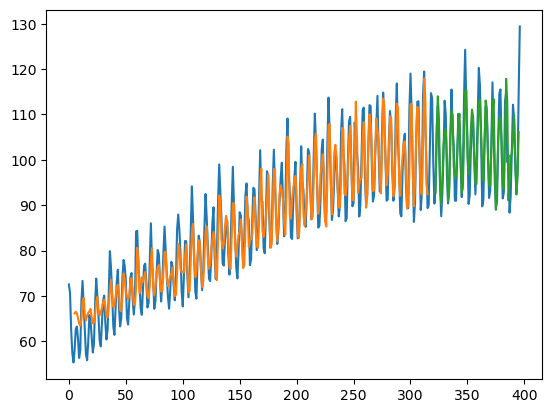

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()